## TF-IDF (uni/bi-grams) → Logistic Regression

In [1]:
import helpers as helpers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

from sklearn.model_selection import GridSearchCV, learning_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/griffinmichalak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# TfidfVectorizer(max_features=50k, ngram_range=(1,2), min_df=2) 

DEPRESSION_PATH = "data/depression_dataset_reddit_cleaned.csv"
TDT_SPLIT = "80/10/10"
MODEL_NAME = "tf_idf"

In [3]:
clean_text, is_depression = helpers.get_data(datapath=DEPRESSION_PATH, tokenize=False, by_character=False)

In [4]:
train_text, dev_text, test_text = helpers.split(data=clean_text, dist=TDT_SPLIT)
train_dep, dev_dep, test_dep = helpers.split(data=is_depression, dist=TDT_SPLIT)

Completing 80/10/10 split
Completing 80/10/10 split


In [5]:
# Handles tokenization internally
model = TfidfVectorizer(max_features=50_000, ngram_range=(1,2), min_df=2)
model.fit(train_text)
train_vectors = model.transform(train_text)
dev_vectors = model.transform(dev_text)
test_vectors = model.transform(test_text)

In [6]:
weight = None
# class_weight='balanced'
lr = LogisticRegression(C = 1.0, max_iter=2000, class_weight=weight, solver='liblinear')
lr.fit(train_vectors, train_dep)

dev_predictions = lr.predict(dev_vectors)

In [7]:
precision = precision_score(dev_dep, dev_predictions)
recall = recall_score(dev_dep, dev_predictions)
f1 = f1_score(dev_dep, dev_predictions)
accuracy = accuracy_score(dev_dep, dev_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.9575070821529745
Recall: 0.8622448979591837
F1: 0.9073825503355705
Accuracy: 0.9107373868046572


In [8]:
# tune logistic regression params using the tf_idf vectors we created

estimator = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'max_iter': [500, 1000, 2000, 5000],
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear']
}

# Grid Search Cross Validation
grid_search = GridSearchCV(estimator, param_grid, scoring='f1', n_jobs=-1)

In [9]:
# fit GridSearchCV on the tf_idf features inside of train_vectors
grid_search.fit(train_vectors, train_dep)

,estimator,LogisticRegression()
,param_grid,"{'C': [0.1, 1, ...], 'class_weight': [None, 'balanced'], 'max_iter': [500, 1000, ...], 'solver': ['liblinear']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [10]:
# gets the best model
grid_search.best_estimator_.score(test_vectors, test_dep)

0.9082687338501292

PR-AUC: 0.9685353384995544
AUC Score: 0.963
Plot saved: results/tf_idf/confusion_tf_idf.png


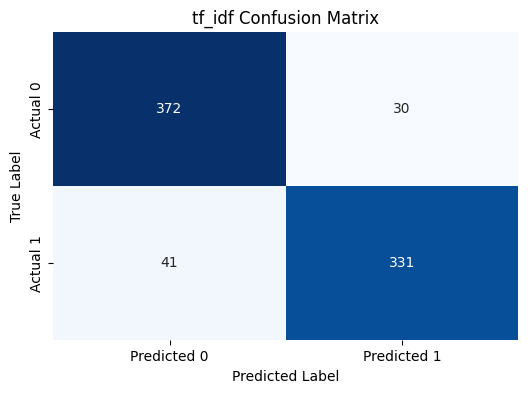

In [11]:
# PR-AUC 
test_probs = grid_search.best_estimator_.predict_proba(test_vectors)[:, 1]
precision_points, recall_points, _ = precision_recall_curve(test_dep, test_probs)
pr_auc = auc(recall_points, precision_points)
print(f"PR-AUC: {pr_auc}")

# ROC-AUC
fpr, tpr, thresholds = roc_curve(test_dep, test_probs)
auc_score = roc_auc_score(test_dep, test_probs)
print(f"AUC Score: {auc_score:.3f}")

# Confusion matrix
test_preds = grid_search.best_estimator_.predict(test_vectors)
cm = confusion_matrix(test_dep, test_preds)

# get test metrics
precision = precision_score(test_dep, test_preds)
recall = recall_score(test_dep, test_preds)
f1 = f1_score(test_dep, test_preds)
accuracy = accuracy_score(test_dep, test_preds)

# show cm
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'{MODEL_NAME} Confusion Matrix')

file_name = f"results/{MODEL_NAME}/confusion_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
    
plt.show()


Plot saved: results/tf_idf/learning_curve_tf_idf.png


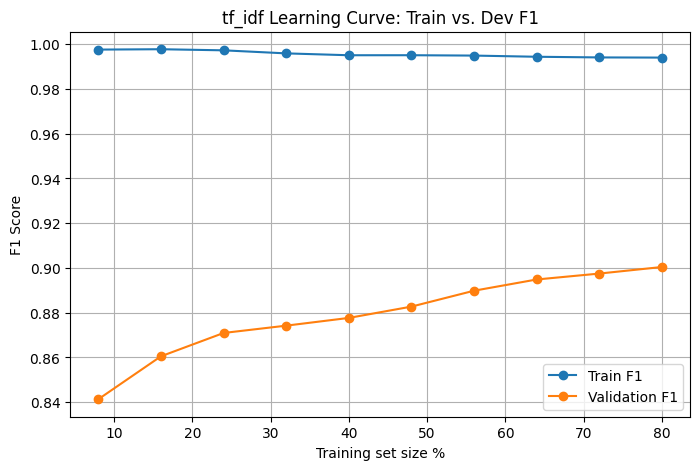

Plot saved: results/tf_idf/pr_tf_idf.png


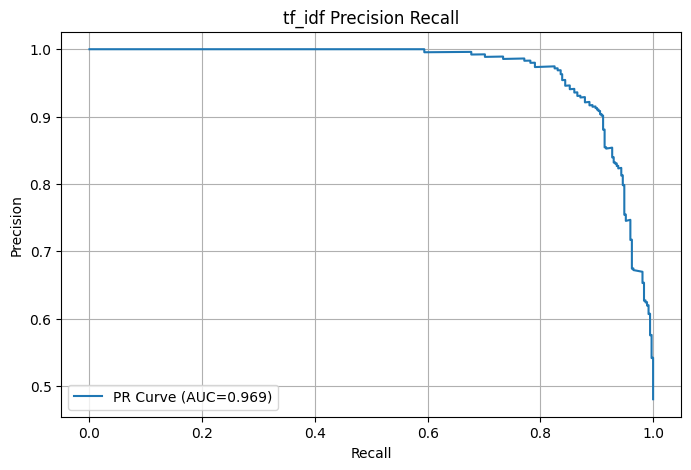

In [12]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
    grid_search.best_estimator_,
    train_vectors,
    train_dep,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes * 100 / train_vectors.shape[0], train_mean, marker='o', label='Train F1')
plt.plot(train_sizes * 100 / train_vectors.shape[0], test_mean, marker='o', label='Validation F1')
plt.xlabel('Training set size %')
plt.ylabel('F1 Score')
plt.title(f'{MODEL_NAME} Learning Curve: Train vs. Dev F1')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/learning_curve_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# PR graph
precision_points, recall_points, _ = precision_recall_curve(test_dep, test_probs)
pr_auc = auc(recall_points, precision_points)

plt.figure(figsize=(8,5))
plt.plot(recall_points, precision_points, label=f'PR Curve (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'{MODEL_NAME} Precision Recall')
plt.legend()
plt.grid(True)

# save graph
file_name = f"results/{MODEL_NAME}/pr_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

## Save to CSV

In [14]:
# lastly, save results to csv

csv_file_name = "results/results.csv"
row = [MODEL_NAME, precision, recall, f1, accuracy, pr_auc, auc_score]

helpers.save_to_csv(csv_file_name, row)

Data appended to results/results.csv


## Ablations

=== N-gram Ablation Results ===
Unigrams only:
  Accuracy: 0.8978
  F1: 0.8937
  Precision: 0.9459
  Recall: 0.8469
Bigrams only:
  Accuracy: 0.8202
  F1: 0.8011
  Precision: 0.9121
  Recall: 0.7143
Unigrams + Bigrams:
  Accuracy: 0.9107
  F1: 0.9074
  Precision: 0.9575
  Recall: 0.8622
Plot saved: results/tf_idf/ablation_ngrams_tf_idf.png


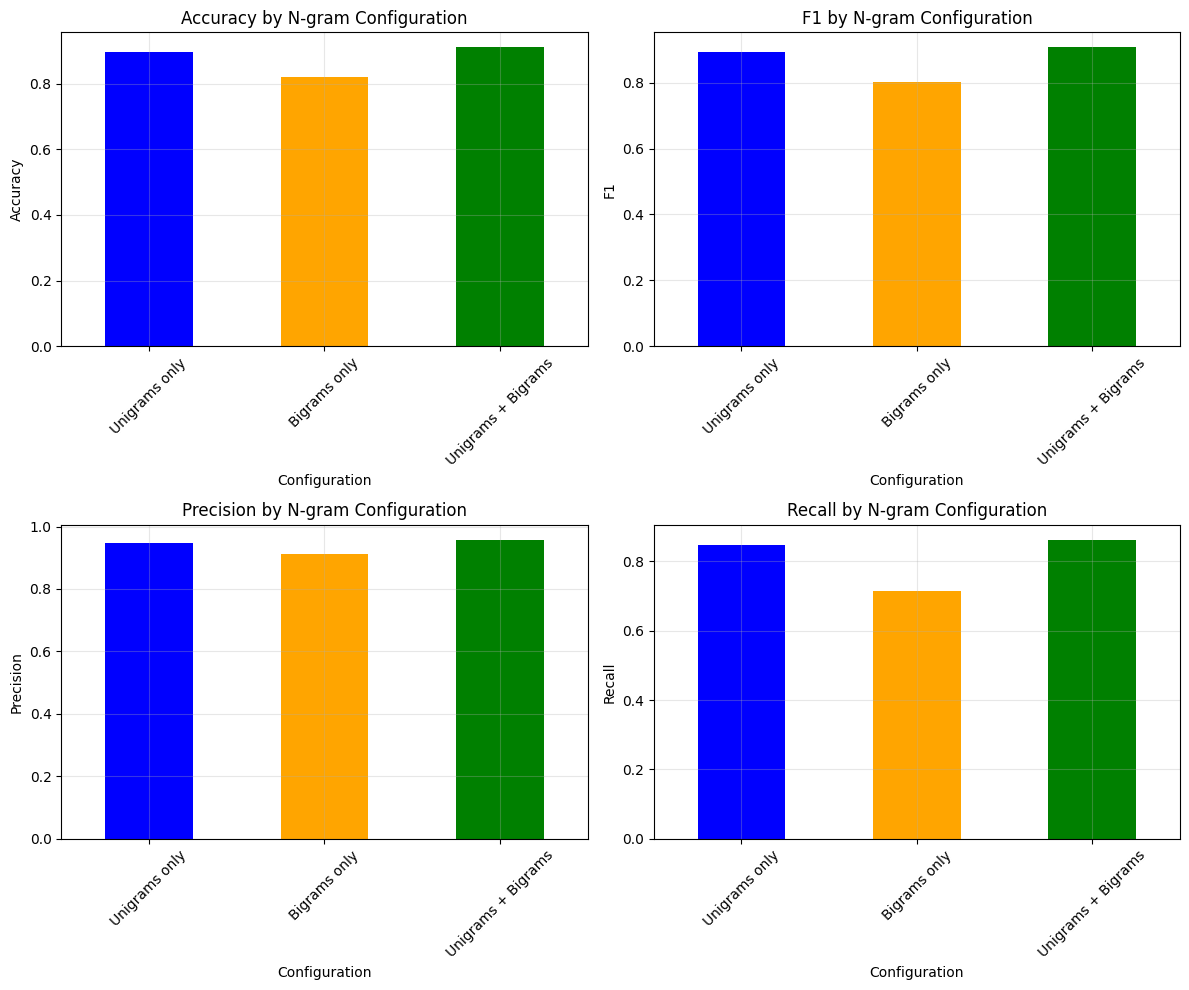

In [ ]:
# ablation
ngram_configs = [
    (1, 1, "Unigrams only"),
    (2, 2, "Bigrams only"),
    (1, 2, "Unigrams + Bigrams")
]

results = {}
for min_n, max_n, name in ngram_configs:
    model = TfidfVectorizer(max_features=50_000, ngram_range=(min_n, max_n), min_df=2)
    model.fit(train_text)
    train_vectors = model.transform(train_text)
    dev_vectors = model.transform(dev_text)
    
    lr = LogisticRegression(C=1.0, max_iter=2000, solver='liblinear')
    lr.fit(train_vectors, train_dep)
    dev_predictions = lr.predict(dev_vectors)
    
    results[name] = {
        'accuracy': accuracy_score(dev_dep, dev_predictions),
        'f1': f1_score(dev_dep, dev_predictions),
        'precision': precision_score(dev_dep, dev_predictions),
        'recall': recall_score(dev_dep, dev_predictions)
    }

print("=== N-gram Ablation Results ===")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  F1: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")

ablation_df = pd.DataFrame(results).T
ablation_df = ablation_df[['accuracy', 'f1', 'precision', 'recall']]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
metrics = ['accuracy', 'f1', 'precision', 'recall']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ablation_df[metric].plot(kind='bar', ax=ax, color=['blue', 'orange', 'green'])
    ax.set_title(f'{metric.capitalize()} by N-gram Configuration')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Configuration')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
file_name = f"results/{MODEL_NAME}/ablation_ngrams_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
plt.show()


=== Class Weighting Ablation ===
No class weighting:
  Accuracy: 0.9107
  F1: 0.9074
  Precision: 0.9575
  Recall: 0.8622
Balanced class weighting:
  Accuracy: 0.9107
  F1: 0.9074
  Precision: 0.9575
  Recall: 0.8622
Plot saved: results/tf_idf/ablation_class_weight_tf_idf.png


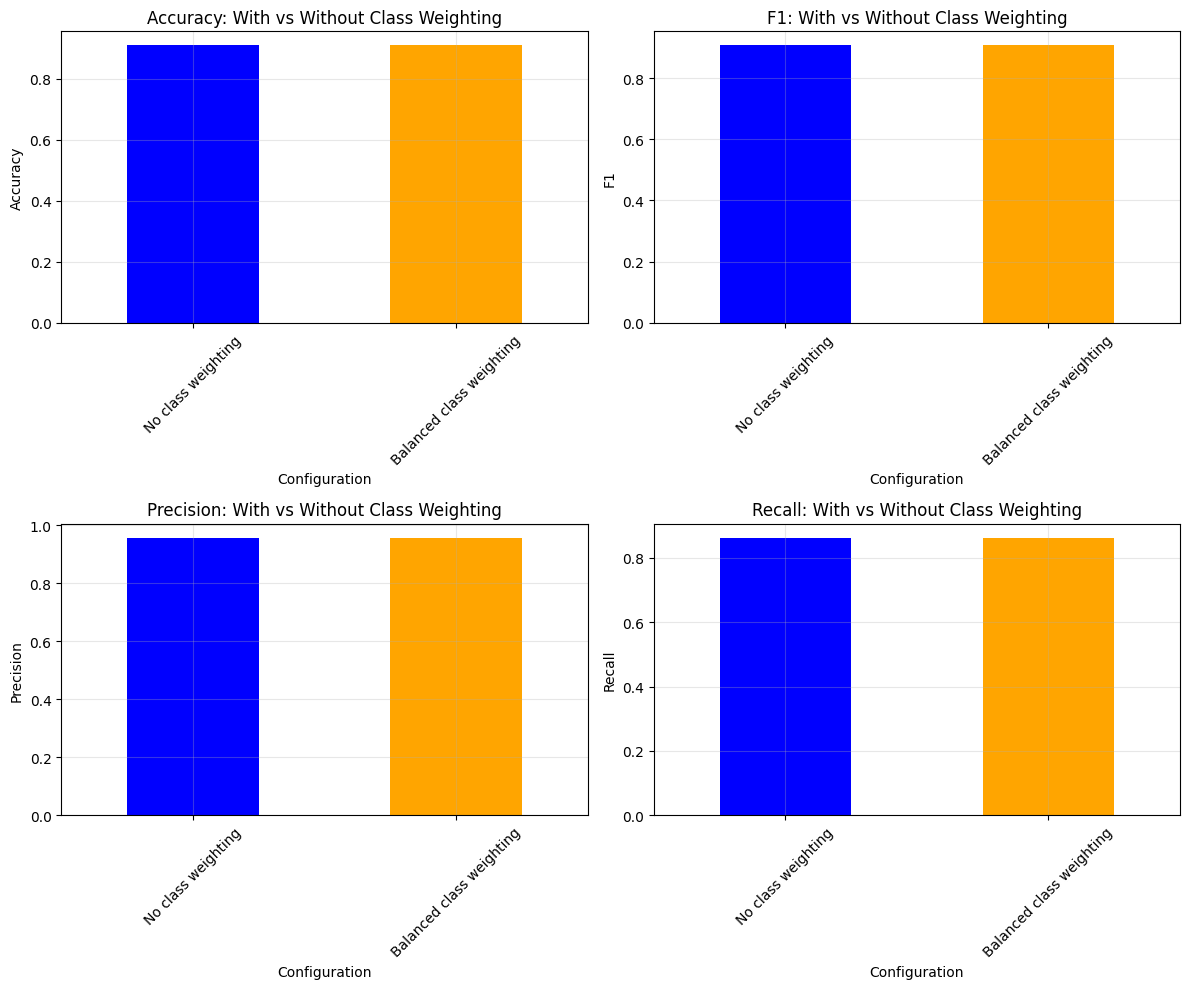

In [32]:
# Class weighting ablation
print("=== Class Weighting Ablation ===")

class_weight_results = {}
for weight_config in [None, 'balanced']:
    lr = LogisticRegression(C=1.0, max_iter=2000, class_weight=weight_config, solver='liblinear')
    lr.fit(train_vectors, train_dep)
    dev_predictions = lr.predict(dev_vectors)
    
    weight_name = "No class weighting" if weight_config is None else "Balanced class weighting"
    class_weight_results[weight_name] = {
        'accuracy': accuracy_score(dev_dep, dev_predictions),
        'f1': f1_score(dev_dep, dev_predictions),
        'precision': precision_score(dev_dep, dev_predictions),
        'recall': recall_score(dev_dep, dev_predictions)
    }
    print(f"{weight_name}:")
    print(f"  Accuracy: {class_weight_results[weight_name]['accuracy']:.4f}")
    print(f"  F1: {class_weight_results[weight_name]['f1']:.4f}")
    print(f"  Precision: {class_weight_results[weight_name]['precision']:.4f}")
    print(f"  Recall: {class_weight_results[weight_name]['recall']:.4f}")

weight_df = pd.DataFrame(class_weight_results).T
weight_df = weight_df[['accuracy', 'f1', 'precision', 'recall']]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, metric in enumerate(['accuracy', 'f1', 'precision', 'recall']):
    ax = axes[idx // 2, idx % 2]
    weight_df[metric].plot(kind='bar', ax=ax, color=['blue', 'orange'])
    ax.set_title(f'{metric.capitalize()}: With vs Without Class Weighting')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Configuration')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
file_name = f"results/{MODEL_NAME}/ablation_class_weight_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
plt.show()

=== Threshold Tuning Ablation ===
Optimal threshold (max F1): 0.450
F1 at optimal threshold: 0.9100
Precision: 0.9307
Recall: 0.8903
Default threshold (0.5):
  F1: 0.9091
  Precision: 0.9401
  Recall: 0.8801
Plot saved: results/tf_idf/ablation_threshold_tf_idf.png


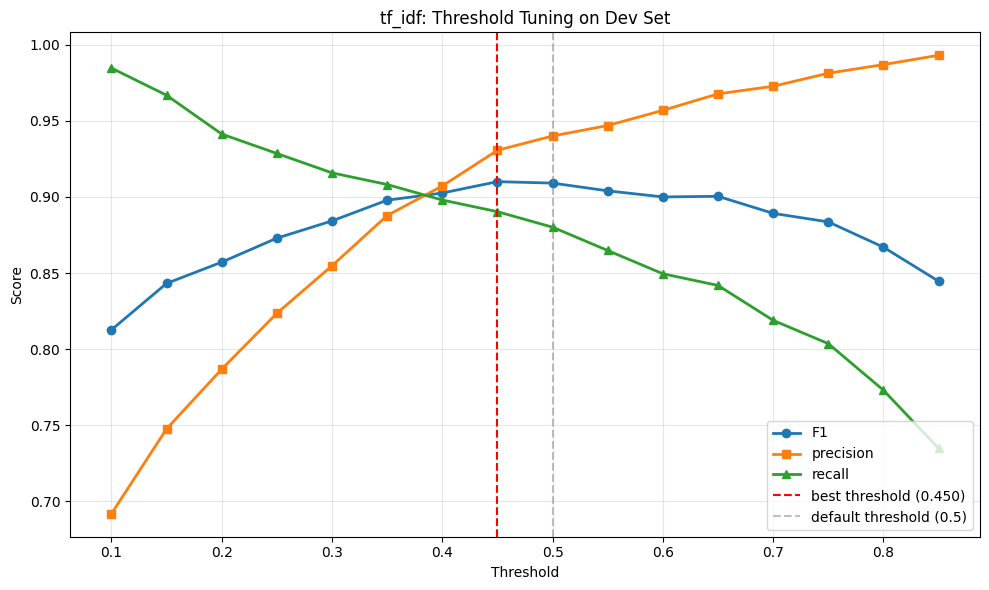

=== Test Set Performance ===
Default threshold (0.5):
  F1: 0.9031
  Precision: 0.9169
  Recall: 0.8898
Optimal threshold (0.450):
  F1: 0.9050
  Precision: 0.9013
  Recall: 0.9086


In [33]:
# Threshold tuning ablation
print("=== Threshold Tuning Ablation ===")

best_model = grid_search.best_estimator_
dev_probs = best_model.predict_proba(dev_vectors)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for threshold in thresholds:
    dev_preds_thresh = (dev_probs >= threshold).astype(int)
    threshold_results.append({
        'threshold': threshold,
        'f1': f1_score(dev_dep, dev_preds_thresh),
        'precision': precision_score(dev_dep, dev_preds_thresh),
        'recall': recall_score(dev_dep, dev_preds_thresh),
        'accuracy': accuracy_score(dev_dep, dev_preds_thresh)
    })

threshold_df = pd.DataFrame(threshold_results)

# maximize f1 to find best threshold
optimal_idx = threshold_df['f1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']
print(f"Optimal threshold (max F1): {optimal_threshold:.3f}")
print(f"F1 at optimal threshold: {threshold_df.loc[optimal_idx, 'f1']:.4f}")
print(f"Precision: {threshold_df.loc[optimal_idx, 'precision']:.4f}")
print(f"Recall: {threshold_df.loc[optimal_idx, 'recall']:.4f}")

# default (0.5) to optimal threshold
default_idx = (threshold_df['threshold'] - 0.5).abs().idxmin()
print(f"Default threshold (0.5):")
print(f"  F1: {threshold_df.loc[default_idx, 'f1']:.4f}")
print(f"  Precision: {threshold_df.loc[default_idx, 'precision']:.4f}")
print(f"  Recall: {threshold_df.loc[default_idx, 'recall']:.4f}")

# Visualize threshold sweep
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['threshold'], threshold_df['f1'], marker='o', label='F1', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['precision'], marker='s', label='precision', linewidth=2)
plt.plot(threshold_df['threshold'], threshold_df['recall'], marker='^', label='recall', linewidth=2)
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f'best threshold ({optimal_threshold:.3f})')
plt.axvline(x=0.5, color='gray', linestyle='--', label='default threshold (0.5)', alpha=0.5)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'{MODEL_NAME}: Threshold Tuning on Dev Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/ablation_threshold_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")
plt.show()

# Apply optimal threshold to test set
test_probs = best_model.predict_proba(test_vectors)[:, 1]
test_preds_optimal = (test_probs >= optimal_threshold).astype(int)
test_preds_default = (test_probs >= 0.5).astype(int)

print("=== Test Set Performance ===")
print(f"Default threshold (0.5):")
print(f"  F1: {f1_score(test_dep, test_preds_default):.4f}")
print(f"  Precision: {precision_score(test_dep, test_preds_default):.4f}")
print(f"  Recall: {recall_score(test_dep, test_preds_default):.4f}")

print(f"Optimal threshold ({optimal_threshold:.3f}):")
print(f"  F1: {f1_score(test_dep, test_preds_optimal):.4f}")
print(f"  Precision: {precision_score(test_dep, test_preds_optimal):.4f}")
print(f"  Recall: {recall_score(test_dep, test_preds_optimal):.4f}")

## TF-IDF & LR: Most/Least Important Features

Plot saved: results/tf_idf/most_tf_idf.png


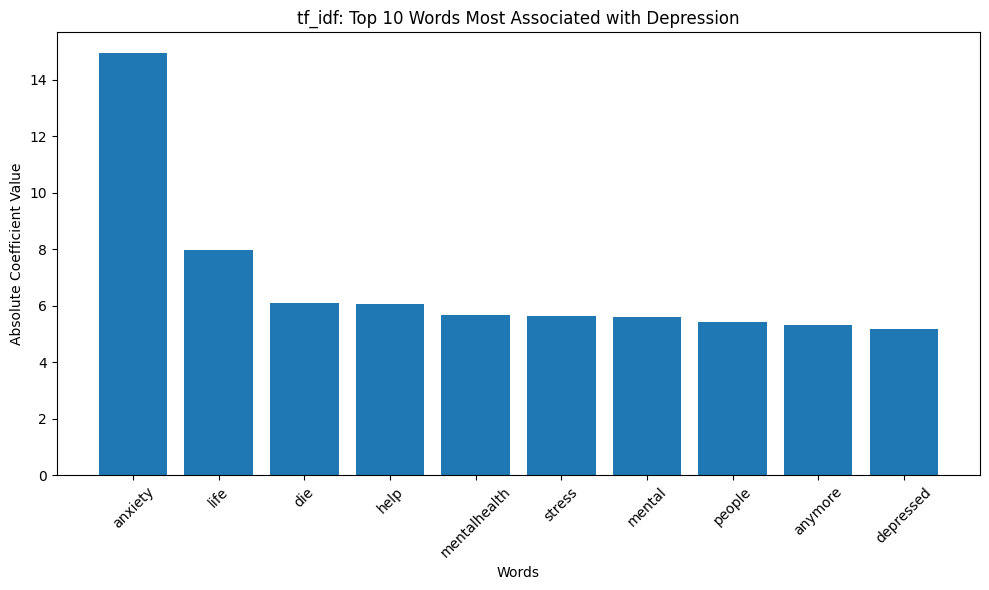

Plot saved: results/tf_idf/least_tf_idf.png


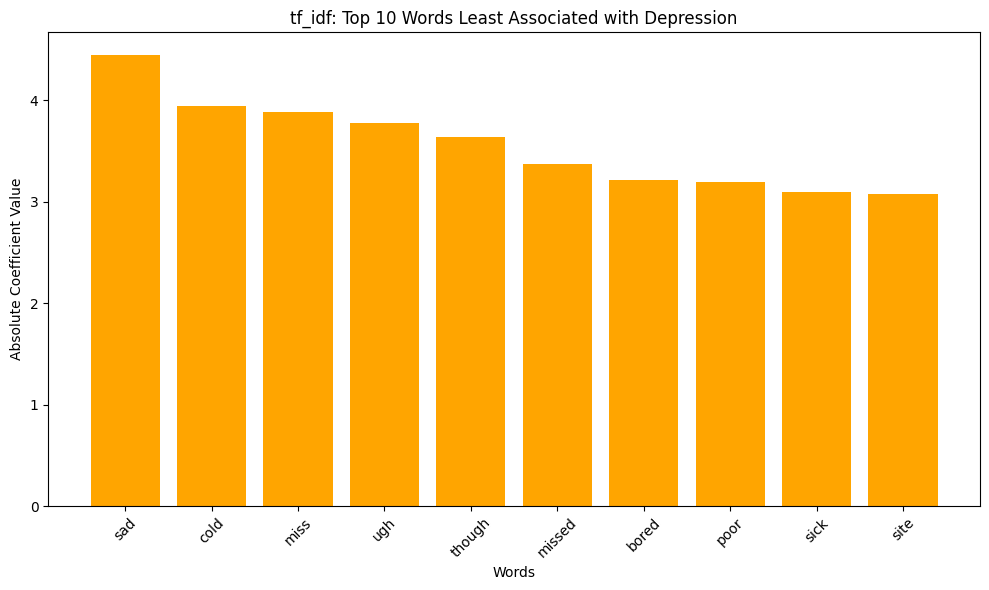

In [15]:
best = grid_search.best_estimator_
feature_names = model.get_feature_names_out()
coefficients = best.coef_[0]

k = 10
sorted_coef = np.sort(coefficients)

# =================================================
# top k words MOST associated with depression
# =================================================

pos_indices = np.argsort(coefficients)[-k:][::-1]
pos_words = feature_names[pos_indices] # top k words MOST associated with depression

plt.figure(figsize=(10,6))
plt.bar(pos_words, coefficients[pos_indices])
plt.xlabel('Words')
plt.ylabel('Absolute Coefficient Value')
plt.title(f'{MODEL_NAME}: Top {k} Words Most Associated with Depression')
plt.xticks(rotation=45)
plt.tight_layout()

file_name = f"results/{MODEL_NAME}/most_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()

# =================================================
# top k words LEAST associated with depression
# =================================================

neg_indices = np.argsort(coefficients)[:k]
neg_words = feature_names[neg_indices] 

plt.figure(figsize=(10,6))
plt.bar(neg_words, abs(coefficients[neg_indices]), color='orange')
plt.xlabel('Words')
plt.ylabel('Absolute Coefficient Value')
plt.title(f'{MODEL_NAME}: Top {k} Words Least Associated with Depression')
plt.xticks(rotation=45)
plt.tight_layout()

# save graph
file_name = f"results/{MODEL_NAME}/least_{MODEL_NAME}.png"
plt.savefig(file_name)
print(f"Plot saved: {file_name}")

plt.show()